In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from skipper import tiling
from astropy import coordinates
from skipper import observe, visualize

### Define COSMOS region

In [3]:
# \\ COSMOS region
center = coordinates.SkyCoord ("10h00m28.6s+02d12m21.0s")
size =  (1.4, 1.4)

edges = [ (center.ra.deg-size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg+size[0]/2.),
          (center.ra.deg-size[0]/2., center.dec.deg+size[0]/2.) ]
#cosmos_area = geometry.Polygon ( edges )

### Create object that generates COSMOS dithering pattern

In [4]:
frd = tiling.FocusedRandomDither (center, random_max=0.1, offset_radius=0.01, ndither=40)

In [5]:
#frd._make_grid ()
#poly_l, area_a, centers = frd.compute_coverage ( cosmos_area )
centers = frd.get_centers ()

Text(0, 0.5, 'Dec (deg)')

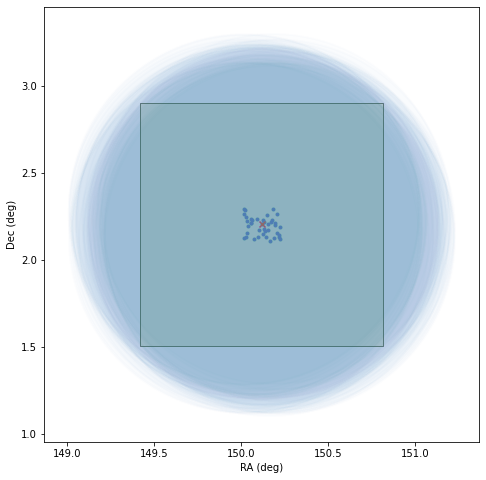

In [6]:
# \\ Visualize the dithering pattern
fig = plt.figure ( figsize=(8,8))
ax = plt.subplot(111, aspect='equal')
rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                         fc='lightgrey', ec='k', alpha=0.5)
ax.add_patch (rect)

for ij in range(frd.ndither):
    patch = patches.Circle ( centers[ij], radius=frd.fov_radius, fc='C0', ec='tab:blue', lw=2, alpha=0.01)
    ax.add_patch(patch)
    ax.scatter(*centers[ij], color='C0', marker='.')
ax.scatter ( *frd.center, color='r', marker='x')

ax.set_xlim ( center.ra.deg - 1.25,  center.ra.deg  + 1.25)
ax.set_ylim ( center.dec.deg- 1.25,  center.dec.deg + 1.25)

ax.set_xlabel ( 'RA (deg)')
ax.set_ylabel ('Dec (deg)')

### Build Observing Catalog and plan nights

In [7]:
# \\ Build observing catalog, and take a quick look
ocat = observe.ObsCatalog(comment='--', proposer='LeathaudGreene')
catalog = ocat.build_catalog(centers[:,0], centers[:,1], 'COSMOS', 'N708', 'science', 10.*60)
catalog.head()

,comment,filter,seqtot,seqnum,expType,object,proposer,program,RA,propid,dec,expTime
0,--,N708,40,1,science,COSMOS,LeathaudGreene,Merian,150.119167,2020B-XXXX,2.205833,600.0
1,--,N708,40,2,science,COSMOS,LeathaudGreene,Merian,150.056213,2020B-XXXX,2.213303,600.0
2,--,N708,40,3,science,COSMOS,LeathaudGreene,Merian,150.219530,2020B-XXXX,2.130318,600.0
3,--,N708,40,4,science,COSMOS,LeathaudGreene,Merian,150.165127,2020B-XXXX,2.110480,600.0
4,--,N708,40,5,science,COSMOS,LeathaudGreene,Merian,150.065493,2020B-XXXX,2.233092,600.0


In [8]:
g09 = pd.read_csv('../json/g09.csv', index_col=0)

In [9]:
mastercat = pd.concat([g09,catalog])
mastercat.index = np.arange(mastercat.index.size)

In [10]:
# \\ Define the observatory site -- default is CTIO
ctio = observe.ObservingSite ()
priorities = {'COSMOS':0}

In [13]:
fmt = '%Y/%m/%d %I:%M %p'

In [15]:
obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, 5 )
obs_end = obs_start + 0.5*(twibeg-obs_start)

print(obs_start.astimezone(ctio.timezone).strftime(fmt))
print(obs_end.astimezone(ctio.timezone).strftime(fmt))

is_queued = ocat.plan_night ( obs_start, ctio, catalog=mastercat, obs_end=obs_end,
                             maxairmass=1.5, object_priority=priorities )

2021/03/05 09:00 PM
2021/03/06 01:57 AM
2021-03-06 04:00:00
==> 20210306_00
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210306_01
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects


/Users/kadofong/env3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


==> 20210306_02
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210306_03
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210306_04
(180s) Not enough time for an exposure. Skipping...


In [16]:
obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, 6)
obs_end = obs_start + 0.5*(twibeg-obs_start)

print(obs_start.astimezone(ctio.timezone).strftime(fmt))
print(obs_end.astimezone(ctio.timezone).strftime(fmt))

is_queued = ocat.plan_night ( obs_start, ctio, catalog=mastercat, obs_end=obs_end,
                             maxairmass=1.5, is_queued=is_queued )

2021/03/06 08:54 PM
2021/03/07 01:54 AM
2021-03-07 04:00:00
==> 20210306_23
(360s) Not enough time for an exposure. Skipping...
==> 20210307_00
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210307_01


/Users/kadofong/env3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210307_02
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210307_03
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210307_04
(360s) Not enough time for an exposure. Skipping...


In [17]:
obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, 7)
obs_end = obs_start + 0.5*(twibeg-obs_start)

print(obs_start.astimezone(ctio.timezone).strftime(fmt))
print(obs_end.astimezone(ctio.timezone).strftime(fmt))

is_queued = ocat.plan_night ( obs_start, ctio, catalog=mastercat, obs_end=obs_end,
                             maxairmass=1.5, is_queued=is_queued )

2021/03/07 08:54 PM
2021/03/08 01:54 AM
2021-03-08 04:00:00
==> 20210307_23
(360s) Not enough time for an exposure. Skipping...
==> 20210308_00
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210308_01


/Users/kadofong/env3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210308_02
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210308_03
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210308_04
(360s) Not enough time for an exposure. Skipping...


In [18]:
obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, 8)
obs_end = obs_start + 0.5*(twibeg-obs_start)

print(obs_start.astimezone(ctio.timezone).strftime(fmt))
print(obs_end.astimezone(ctio.timezone).strftime(fmt))

is_queued = ocat.plan_night ( obs_start, ctio, catalog=mastercat, obs_end=obs_end,
                             maxairmass=1.5, is_queued=is_queued )

2021/03/08 08:54 PM
2021/03/09 01:54 AM
2021-03-09 04:00:00
==> 20210308_23
(360s) Not enough time for an exposure. Skipping...
==> 20210309_00
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210309_01


/Users/kadofong/env3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210309_02
2400.0s filled by priority=0.0 objects
1200.0s filled by priority=inf objects
==> 20210309_03
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210309_04
(360s) Not enough time for an exposure. Skipping...


In [19]:
assert is_queued.query('has_priority==0.')['is_queued'].all()

# Visualize queued pointings

In [20]:
from shapely import geometry
from descartes.patch import PolygonPatch
from astropy import units as u

In [21]:
g09edges = np.loadtxt('../data/g09edge.dat')
poly_g09 = geometry.Polygon(g09edges)  
print('The GAMA09 field area is: ' + str(poly_g09.area))
print('Fraction of the entire Merian Survey is: '+str(100*poly_g09.area/800))

The GAMA09 field area is: 140.6957220611181
Fraction of the entire Merian Survey is: 17.58696525763976


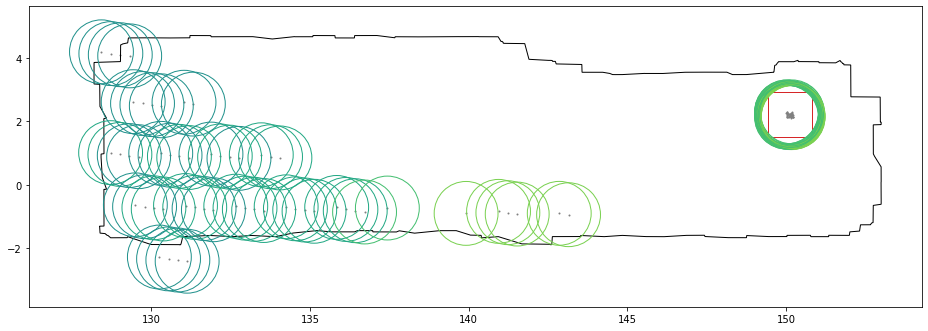

In [22]:
tq = mastercat.loc[is_queued.is_queued]
fov_radius = (3.18/np.pi)**0.5
plt.figure(figsize=(16,16))
ax = plt.subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
ax.add_patch(patch1)

cosmos = patches.Rectangle ( ((center.ra - size[0]/2.*u.deg).value, 
                              (center.dec - size[1]/2.*u.deg).value),
                             *size, fc='None', ec='tab:red')
ax.add_patch(cosmos)

for name,row in tq.iterrows():
    timestamp = datetime.datetime.strptime (is_queued.loc[name,'qstamp'], '%Y%m%d_%H')
    if timestamp.hour>12:
        hr = timestamp.hour - 24.
    else:
        hr = timestamp.hour
    patch = patches.Circle ( (row.RA, row.dec), fov_radius, ec=plt.cm.viridis((hr+5)/10.), 
                            fc='None')
    
    ax.add_patch(patch)
        
ax.scatter(tq.RA, tq.dec, s=1, color='grey')